In [54]:
import numpy as np
import pandas as pd
import subprocess
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
%%bash
source ~/.bashrc
conda activate gatk4
gatk CreateSequenceDictionary \
    R=/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta \
    O=/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.dict

Using GATK jar /storage/group/ibb3/default/.conda/envs/gatk4/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /storage/group/ibb3/default/.conda/envs/gatk4/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar CreateSequenceDictionary R=/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta O=/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.dict
INFO	2024-01-02 11:06:48	CreateSequenceDictionary	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the ne

Tool returned:
0


In [11]:
!sbatch ../liftover.sh ; cat ../liftover.sh

sbatch: slurm_job_submit: No account set, using default acct: open
Submitted batch job 8135022
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks=20
#SBATCH --mem=128GB
#SBATCH --time=48:00:00
#SBATCH --job-name=lifto

source ~/.bashrc
conda activate gatk4
gatk --java-options '-Xmx128G' LiftoverVcf \
    I=../snpchip.vcf \
    O=../lifted_over.vcf \
    CHAIN=../Adig_Apalm.liftover.chain \
    REJECT=../rejected_variants.vcf \
    R=/storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta


In [64]:
%%bash
grep "^#" ../lifted_over.vcf \
    | sed "s/Sc0a5M3/Apal_Sc0a5M3/g" \
    | sed "s/hic_scaffold/Apal_hic_scaffold/g" \
    > ../lifted_over_headerfix.vcf

In [62]:
vcf = pd.read_csv("../lifted_over.vcf", sep = "\t", header = None, comment = "#")
vcf[0] = "Apal_" + vcf[0]

In [63]:
vcf_original_columns = vcf.columns.tolist()

In [65]:
vcf = vcf.drop_duplicates([0,1]).reset_index(drop=True)

In [66]:
bed = pd.read_csv("../references/apal_and_sym.bed", sep = "\t", header = None)
bed = bed.reset_index(drop=False)

In [67]:
vcf = vcf.merge(bed[["index", 0]], how = "left", on = 0).sort_values(["index", 1]).reset_index(drop=True)
vcf = vcf[vcf_original_columns]
vcf[1] = vcf[1].astype(int)

In [68]:
bed = pd.read_csv("../references/apal_and_sym.bed", sep = "\t", header = None)
bed = bed.reset_index(drop=False)

In [69]:
vcf = vcf.merge(bed[["index", 0]], how = "left", on = 0).sort_values(["index", 1]).reset_index(drop=True)
vcf = vcf[vcf_original_columns]
vcf[1] = vcf[1].astype(int)

In [70]:
vcf = vcf[vcf[0].isin(pd.DataFrame(vcf[0].value_counts().head(14)).index)]

In [71]:
vcf.set_index(0).to_csv("../lifted_over_headerfix.vcf", 
                        mode="a", header=False, sep = "\t")

In [75]:
%%bash
source ~/.bashrc
conda activate ipyrad
bgzip ../lifted_over_headerfix.vcf
tabix ../lifted_over_headerfix.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [76]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools isec -p ../isec_output -Oz ../lifted_over_headerfix.vcf.gz ../shapeit_phase/all.phased_tagged.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
Process is interrupted.


Now we'll test with the microarray data from our hold out individuals. Unfortunately for us, the first step for us is to liftover the coordinates from the microarray over to the Acropora palmata reference. There's probably a more elegant way but this works well. The coordinates from the microarray utilize A. digitifera genomic coordinates and REF/ALT alleles. So these all need to be adjusted if we want to impute the microarray data:

In [26]:
%%bash
source ~/.bashrc
conda activate ipyrad
bwa mem \
    ../references/apal_and_sym.fa \
    /storage/group/ibb3/default/convert_snpchip_coords/probes.fasta \
    > ../probes_aln_apal.sam

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 53589 sequences (3803707 bp)...
[M::mem_process_seqs] Processed 53589 reads in 3.906 CPU sec, 3.919 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem ../references/apal_and_sym.fa /storage/group/ibb3/default/convert_snpchip_coords/probes.fasta
[main] Real time: 14.115 sec; CPU: 7.960 sec


In [181]:
%%bash
source ~/.bashrc
conda activate ipyrad
sambamba view -S -F "not unmapped and not secondary_alignment and not supplementary and not reverse_strand" \
    ../probes_aln_apal.sam > ../probes_aln_apal_fw_strand.sam
sambamba view -S -F "not unmapped and not secondary_alignment and not supplementary and reverse_strand" \
    ../probes_aln_apal.sam > ../probes_aln_apal_rv_strand.sam

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



sambamba 0.7.1
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)


sambamba 0.7.1
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)



In [73]:
%%bash
cut -f1,3,4,5,6,10,12 ../probes_aln_apal.sam \
    > ../probes_aln_apal.tab

In [184]:
%%bash
cut -f1,3,4,5,6,10,12 ../probes_aln_apal_fw_strand.sam \
    > ../probes_aln_apal_fw.tab
cut -f1,3,4,5,6,10,12 ../probes_aln_apal_rv_strand.sam \
    > ../probes_aln_apal_rv.tab

In [82]:
probes = pd.read_csv("../probes_aln_apal.tab", 
                     comment = "@", sep = "\t", 
                     names = ["probe", "contig", "start", "mapq", "cigar", "seq", "mismatch"])

In [83]:
probes = probes[~probes["cigar"].str.contains("H")].reset_index(drop=True)
probes = probes[probes["mapq"] > 20].reset_index(drop=True)
probes["npos"] = np.nan
for i in range(len(probes)):
    probes["npos"][i] = probes["seq"][i].find("N")

/tmp/ipykernel_17993/3945460045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["npos"][i] = probes["seq"][i].find("N")


In [84]:
probes["new_snp_pos"] = np.nan

In [85]:
probes.loc[~probes["cigar"].str.contains("I|D"), "new_snp_pos"] = probes["npos"]

In [90]:
probes["new_snp_pos"] = probes["start"] + probes["npos"]

for i in range(len(probes)):
    cigar = re.findall('(\d+)?([A-Za-z])', probes["cigar"][i])
    length = len(cigar)
    if (length < 4) and (length > 2):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ) and ( cigar[2][1] == "S" ):
            print
        elif ( cigar[0][1] == "M" ) and ( cigar[2][1] == "M" ):
            if int(cigar[0][0]) > probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
            elif int(cigar[0][0]) < probes["seq"][i].find("N"):
                if cigar[1][1] == "I":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") + int(cigar[1][0])
                elif cigar[1][1] == "D":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") - int(cigar[1][0])
    if (length > 3):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ):
            if (int(cigar[0][0]) + int(cigar[1][0])) >= probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
    if ( cigar[0][1] == "M" ) and ( int(cigar[0][0]) >= probes["seq"][i].find("N") ):
        probes["new_snp_pos"][i] = probes["seq"][i].find("N")

In [92]:
probes = probes[probes["new_snp_pos"].notna()].reset_index(drop=True)
probes["new_snp_pos"] = probes["new_snp_pos"].astype(int)

In [93]:
!rm ../probes_in_apal.txt

In [94]:
file = open('../probes_in_apal.txt','w')
for item in probes["probe"].tolist():
    file.write(item+"\n")
file.close()

In [95]:
%%bash
source ~/.bashrc
conda activate ipyrad
vcftools --vcf ../snpchip.vcf \
    --snps ../probes_in_apal.txt \
    --recode --out ../snpchip_conserved_probes

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../snpchip.vcf
	--out ../snpchip_conserved_probes
	--recode
	--snps ../probes_in_apal.txt

After filtering, kept 2077 out of 2077 Individuals
Outputting VCF file...
After filtering, kept 39463 out of a possible 53589 Sites
Run Time = 328.00 seconds


In [130]:
reformat = probes[["contig", "new_snp_pos", "probe"]]
reformat.columns = ["contig", "start", "ID"]
reformat = reformat.drop_duplicates(["contig", "start"]).reset_index(drop=True)

In [131]:
tmp = pd.read_csv("../original_coords_apal.tab", sep = "\t")
tmp = tmp.merge(reformat, how = "left", on = "ID")
tmp.columns = [0, 1, 2, "contig", "start"]

In [134]:
tmp = tmp[~tmp["contig"].isna()][~tmp["start"].isna()].reset_index(drop=True)

/tmp/ipykernel_17993/1794811467.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[~tmp["contig"].isna()][~tmp["start"].isna()].reset_index(drop=True)


In [192]:
conserved = pd.read_csv("../snpchip_conserved_probes.recode.vcf", sep = "\t", comment = "#", header = None)

In [193]:
conserved = conserved.merge(tmp, how = "left", on = [0,1,2])

In [194]:
conserved = conserved[~conserved["contig"].isna()][~conserved["start"].isna()].reset_index(drop=True)

/tmp/ipykernel_17993/530618696.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  conserved = conserved[~conserved["contig"].isna()][~conserved["start"].isna()].reset_index(drop=True)


In [196]:
conserved = conserved[["contig", "start"] + conserved.columns.tolist()[2:2086]]

In [198]:
%%bash
grep "^#" ../snpchip_conserved_probes.recode.vcf \
    > ../snpchip_conserved_probes.remapped.vcf

In [199]:
conserved.set_index("contig").to_csv("../snpchip_conserved_probes.remapped.vcf", 
                        mode="a", header=False, sep = "\t")

In [200]:
vcf = pd.read_csv("../snpchip_conserved_probes.remapped.vcf", sep = "\t", comment = "#", header = None)
vcf[1] = vcf[1].astype(int)

In [201]:
vcf_original_columns = vcf.columns.tolist()

In [202]:
vcf = vcf[vcf[0].notna()].reset_index(drop=True)

In [203]:
vcf["true_ref"] = np.nan

In [204]:
from Bio import SeqIO

In [205]:
SeqDict = SeqIO.to_dict(SeqIO.parse("../references/apal_and_sym.fa", "fasta"))

In [206]:
for i in range(len(vcf)):
    vcf["true_ref"][i] = SeqDict[vcf[0][i]].seq[vcf[1][i] - 1]
vcf["true_ref"] = vcf["true_ref"].str.upper()

/tmp/ipykernel_17993/3329947683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf["true_ref"][i] = SeqDict[vcf[0][i]].seq[vcf[1][i] - 1]


In [207]:
rvs = pd.read_csv("../probes_aln_apal_rv.tab", comment = "@", sep = "\t", 
                     names = ["probe", "contig", "start", "mapq", "cigar", "seq", "mismatch"])

In [208]:
rvstrand = vcf.loc[vcf[2].isin(rvs["probe"].tolist())].reset_index(drop=True)
fwstrand = vcf.loc[~vcf[2].isin(rvs["probe"].tolist())].reset_index(drop=True)

In [212]:
for cols in [3, 4]:
    rvstrand[cols] = rvstrand[cols].replace({ 'T' : 'A', 'A' : 'T', 'C' : 'G', 'G' : 'C' }, regex=True)

In [213]:
vcf = pd.concat([fwstrand, rvstrand]).reset_index(drop=True)

In [217]:
vcf = vcf.loc[(vcf["true_ref"] == vcf[4] ) | (vcf["true_ref"] == vcf[3] )].reset_index(drop=True)

In [219]:
vcf.update(vcf.loc[vcf["true_ref"] != vcf[3]].replace({ '0/0' : '1/1', '1/1' : '0/0' }, regex=True))

In [220]:
vcf.loc[vcf[3] != vcf["true_ref"], 4] = vcf[3]
vcf.loc[vcf[3] != vcf["true_ref"], 3] = vcf["true_ref"]

In [222]:
bed = pd.read_csv("../references/apal_and_sym.bed", sep = "\t", header = None)
bed = bed.reset_index(drop=False)

In [225]:
vcf = vcf.merge(bed[["index", 0]], how = "left", on = 0).sort_values(["index", 1]).reset_index(drop=True)
vcf = vcf[vcf_original_columns]
vcf[1] = vcf[1].astype(int)

In [227]:
%%bash
grep "^#" ../snpchip_conserved_probes.recode.vcf \
    > ../apal_coords_snpchip_conserved_probes.recode.vcf

In [228]:
vcf.set_index(0).to_csv("../apal_coords_snpchip_conserved_probes.recode.vcf", 
                        mode="a", header=False, sep = "\t")

In [229]:
!grep -v "^#" ../apal_coords_snpchip_conserved_probes.recode.vcf | wc -l

19622


#### With all that, we now have a lifted over VCF where the microarray data uses Apal coords and Apal REF/ALT alleles. Now we can proceed with imputation and with evaluation of microarray vs microarray imputed vs "truth" (seq data):

In [230]:
%%bash
source ~/.bashrc
conda activate ipyrad
bgzip ../apal_coords_snpchip_conserved_probes.recode.vcf
tabix ../apal_coords_snpchip_conserved_probes.recode.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [235]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools merge ../apal_coords_snpchip_conserved_probes.recode.vcf.gz \
    apal_imputation_panel_hifi_illumina.vcf.gz \
    --threads 8 \
    -O z > ~/scratch/apal_sr_and_microarray_joined.vcf.gz
tabix ~/scratch/apal_sr_and_microarray_joined.vcf.gz

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [36]:
!zcat ../apal_coords_snpchip_conserved_probes.recode.vcf.gz | grep -v "^#" | cut -f1-2 > ../microarray_positions.tsv

Since we've joined the microarray data with the WGS data, we can use microarray-specific SNPs to determine relatedness. In unpublished and published materials, it's been shown that the KING-robust values are well calibrated with true levels of relatedness in the SNPs designed on the coral-algae Axiom array. Here we'll do just that and exclude clones, parent-offspring, and parent-sibling relationships by preserving only one individual in the family groups:

In [9]:
%%bash
source ~/.bashrc
conda activate ipyrad
bcftools query -l ../calls/apal_imputation_panel_hifi_illumina.vcf.gz \
    > ./wgs_samples.txt

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [40]:
%%bash
source ~/.bashrc
conda activate beagle
bcftools view --targets-file ../microarray_positions.tsv \
    ~/scratch/apal_sr_and_microarray_joined.vcf.gz \
    -O z > ~/scratch/kin_sr_microarray.vcf.gz

In [43]:
%%bash
source ~/.bashrc
conda activate ipyrad
plink2 --vcf ~/scratch/kin_sr_microarray.vcf.gz \
    --threads 20 \
    --maf 0.1 \
    --allow-extra-chr \
    --geno 0.9 \
    --make-king-table --out ~/scratch/kin_sr_microarray

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /storage/home/nsl5160/scratch/kin_sr_microarray.log.
Options in effect:
  --allow-extra-chr
  --geno 0.9
  --maf 0.1
  --make-king-table
  --out /storage/home/nsl5160/scratch/kin_sr_microarray
  --threads 20
  --vcf /storage/home/nsl5160/scratch/kin_sr_microarray.vcf.gz

Start time: Wed Jan 24 18:08:33 2024
257826 MiB RAM detected; reserving 128913 MiB for main workspace.
Using up to 20 threads (change this with --threads).
--vcf: 19723 variants scanned.
--vcf: /storage/home/nsl5160/scratch/kin_sr_microarray-temporary.pgen +
/storage/home/nsl5160/scratch/kin_sr_microarray-temporary.pvar +
/storage/home/nsl5160/scratch/kin_sr

In [99]:
%%bash
source ~/.bashrc
conda activate ipyrad
plink2 --vcf ~/scratch/kin_sr_microarray.vcf.gz \
    --threads 20 \
    --maf 0.1 \
    --allow-extra-chr \
    --geno 0.9 \
    --make-king-table \
    --keep ./wgs_samples.txt \
    --out ~/scratch/kin_sr_only_wgs

plink2 --vcf ~/scratch/kin_sr_microarray.vcf.gz \
    --threads 20 \
    --maf 0.1 \
    --allow-extra-chr \
    --geno 0.9 \
    --king-cutoff 0.3536 \
    --keep ./wgs_samples.txt \
    --out ~/scratch/kin_sr_only_wgs_0.3536

plink2 --vcf ~/scratch/kin_sr_microarray.vcf.gz \
    --threads 20 \
    --maf 0.1 \
    --allow-extra-chr \
    --geno 0.9 \
    --king-cutoff 0.1768 \
    --keep ./wgs_samples.txt \
    --out ~/scratch/kin_sr_only_wgs_0.1768
    
plink2 --vcf ~/scratch/kin_sr_microarray.vcf.gz \
    --threads 20 \
    --maf 0.1 \
    --allow-extra-chr \
    --geno 0.9 \
    --king-cutoff 0.0884 \
    --keep ./wgs_samples.txt \
    --out ~/scratch/kin_sr_only_wgs_0.0884

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
PLINK v2.00a2.3LM 64-bit Intel (24 Jan 2020)   www.cog-genomics.org/plink/2.0/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /storage/home/nsl5160/scratch/kin_sr_only_wgs.log.
Options in effect:
  --allow-extra-chr
  --geno 0.9
  --keep ./wgs_samples.txt
  --maf 0.1
  --make-king-table
  --out /storage/home/nsl5160/scratch/kin_sr_only_wgs
  --threads 20
  --vcf /storage/home/nsl5160/scratch/kin_sr_microarray.vcf.gz

Start time: Wed Jan 24 19:07:42 2024
257826 MiB RAM detected; reserving 128913 MiB for main workspace.
Using up to 20 threads (change this with --threads).
--vcf: 19723 variants scanned.
--vcf: /storage/home/nsl5160/scratch/kin_sr_only_wgs-temporary.pgen +
/storage/home/nsl5160/scratch/kin_sr_only_wgs-temporary.pvar +
/storage/home/nsl

In [46]:
relatedness = pd.read_csv("/storage/home/nsl5160/scratch/kin_sr_only_wgs.kin0", sep = "\t")

Just to confirm, here's a plot of the KINSHIP values. We should see most values ~0 and then tiny peaks at 0.25 and 0.5 (siblings and clones, respectively). We have known clones and known siblings in the dataset so this is good confirmation of this all working:

/tmp/ipykernel_4088209/1254866713.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(relatedness["KINSHIP"][relatedness["#ID1"].isin(wgssamples["Sample"])][relatedness["ID2"].isin(wgssamples["Sample"])])


<Axes: xlabel='KINSHIP', ylabel='Density'>

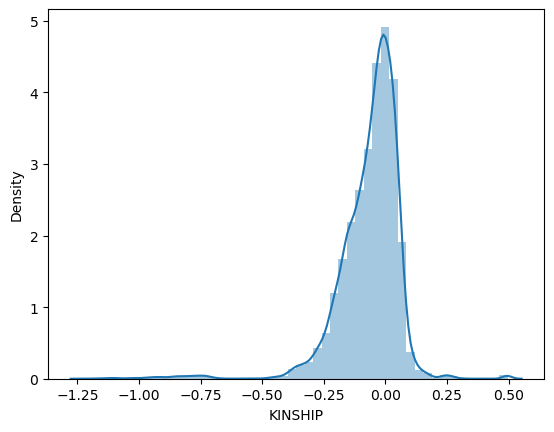

In [58]:
sns.distplot(relatedness["KINSHIP"][relatedness["#ID1"].isin(wgssamples["Sample"])][relatedness["ID2"].isin(wgssamples["Sample"])])